# 多GPU的简洁实现
:label:`sec_multi_gpu_concise`

每个新模型的并行计算都从零开始实现是无趣的。此外，优化同步工具以获得高性能也是有好处的。下面我们将展示如何使用深度学习框架的高级API来实现这一点。数学和算法与 :numref:`sec_multi_gpu`中的相同。本节的代码至少需要两个GPU来运行。


In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

## [**简单网络**]

让我们使用一个比 :numref:`sec_multi_gpu`的LeNet更有意义的网络，它依然能够容易地和快速地训练。我们选择的是 :cite:`He.Zhang.Ren.ea.2016`中的ResNet-18。因为输入的图像很小，所以稍微修改了一下。与 :numref:`sec_resnet`的区别在于，我们在开始时使用了更小的卷积核、步长和填充，而且删除了最大汇聚层。


In [ ]:
#@save
def resnet18(num_classes, in_channels=1):
    """稍加修改的ResNet-18模型"""
    def resnet_block(in_channels, out_channels, num_residuals,
                     first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(d2l.Residual(in_channels, out_channels,
                                        use_1x1conv=True, strides=2))
            else:
                blk.append(d2l.Residual(out_channels, out_channels))
        return nn.Sequential(*blk)

    # 该模型使用了更小的卷积核、步长和填充，而且删除了最大汇聚层
    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU())
    net.add_module("resnet_block1", resnet_block(
        64, 64, 2, first_block=True))
    net.add_module("resnet_block2", resnet_block(64, 128, 2))
    net.add_module("resnet_block3", resnet_block(128, 256, 2))
    net.add_module("resnet_block4", resnet_block(256, 512, 2))
    net.add_module("global_avg_pool", nn.AdaptiveAvgPool2d((1,1)))
    net.add_module("fc", nn.Sequential(nn.Flatten(),
                                       nn.Linear(512, num_classes)))
    return net

## 网络初始化


我们将在训练回路中初始化网络。请参见 :numref:`sec_numerical_stability`复习初始化方法。


In [7]:
net = resnet18(10)
# 获取GPU列表
devices = d2l.try_all_gpus()
# 我们将在训练代码实现中初始化网络

## [**训练**]

如前所述，用于训练的代码需要执行几个基本功能才能实现高效并行：

* 需要在所有设备上初始化网络参数；
* 在数据集上迭代时，要将小批量数据分配到所有设备上；
* 跨设备并行计算损失及其梯度；
* 聚合梯度，并相应地更新参数。

最后，并行地计算精确度和发布网络的最终性能。除了需要拆分和聚合数据外，训练代码与前几章的实现非常相似。


In [8]:
def train(net, num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    print(devices)
    def init_weights(m):
        if type(m) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)
    # 在多个GPU上设置模型
    # net = nn.DataParallel(net, device_ids=devices)
    net = nn.DataParallel(net, device_ids=[0,1])
    trainer = torch.optim.SGD(net.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    timer, num_epochs = d2l.Timer(), 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        net.train()
        timer.start()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        timer.stop()
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(net, test_iter),))
    print(f'测试精度：{animator.Y[0][-1]:.2f}，{timer.avg():.1f}秒/轮，'
          f'在{str(devices)}')

接下来看看这在实践中是如何运作的。我们先[**在单个GPU上训练网络**]进行预热。


In [9]:
# train(net, num_gpus=1, batch_size=256, lr=0.1)

接下来我们[**使用2个GPU进行训练**]。与 :numref:`sec_multi_gpu`中评估的LeNet相比，ResNet-18的模型要复杂得多。这就是显示并行化优势的地方，计算所需时间明显大于同步参数需要的时间。因为并行化开销的相关性较小，因此这种操作提高了模型的可伸缩性。


[device(type='cuda', index=0)]


RuntimeError: module must have its parameters and buffers on device cuda:0 (device_ids[0]) but found one of them on device: cpu

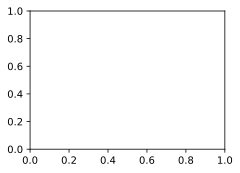

In [11]:
train(net, num_gpus=1, batch_size=256, lr=0.2)

## 小结


* 神经网络可以在（可找到数据的）单GPU上进行自动评估。
* 每台设备上的网络需要先初始化，然后再尝试访问该设备上的参数，否则会遇到错误。
* 优化算法在多个GPU上自动聚合。


## 练习


1. 本节使用ResNet-18，请尝试不同的迭代周期数、批量大小和学习率，以及使用更多的GPU进行计算。如果使用$16$个GPU（例如，在AWS p2.16xlarge实例上）尝试此操作，会发生什么？
1. 有时候不同的设备提供了不同的计算能力，我们可以同时使用GPU和CPU，那应该如何分配工作？为什么？


[Discussions](https://discuss.d2l.ai/t/2803)
